# Using CellHint for cell type harmonisation
This notebook showcases how to perform cross-dataset cell type harmonisation using CellHint.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/cellhint#usage-harmonisation) if you want to learn more.

## We try to answer three questions:
- Different labs annotate cell types differently (naming convention, annotation resolution, etc.) - how to unify these cell types into a common framework?
- Transcriptome-based hierarchical clustering of cell types does not necessarily mirror biological lineages - how to integrate knowledge across studies to reflect cell type hierarchies?
- Cells are usually annotated only by the dataset of origin - how to re-annotate these cells within the context of multiple studies?

## Download and process four spleen datasets

In [1]:
import scanpy as sc

In [2]:
adata = sc.read('cellhint_demo_folder/Spleen.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Resources/Organ_atlas/Spleen/Spleen.h5ad')
adata

  0%|          | 0.00/4.65G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 200664 × 74369
    obs: 'Dataset', 'donor_id', 'development_stage', 'sex', 'suspension_type', 'assay', 'Original_annotation', 'CellTypist_harmonised_group', 'cell_type', 'Curated_annotation'
    var: 'exist_in_Madissoon2020', 'exist_in_Tabula2022', 'exist_in_DominguezConde2022', 'exist_in_He2020'
    uns: 'schema_version', 'title'
    obsm: 'X_umap'

This dataset combines cells from four studies, and is one of the [organ atlases](https://www.celltypist.org/organs) in CellTypist.

In [3]:
adata.obs.Dataset.value_counts()

Madissoon et al. 2020          92049
Dominguez Conde et al. 2022    70099
Tabula Sapiens 2022            34004
He et al. 2020                  4512
Name: Dataset, dtype: int64

Log-normalised gene expression (to 10,000 counts per cell) is in `.X`, and raw counts are in `.raw`. CellHint does not rely on the latter, but here we still start from raw counts for completeness of a single-cell pipeline.

In [4]:
adata = adata.raw.to_adata()

Delete everything in the adata except `.X` and `.obs` for clarity of this tutorial.

In [5]:
del adata.var
del adata.uns
del adata.obsm
adata

AnnData object with n_obs × n_vars = 200664 × 74369
    obs: 'Dataset', 'donor_id', 'development_stage', 'sex', 'suspension_type', 'assay', 'Original_annotation', 'CellTypist_harmonised_group', 'cell_type', 'Curated_annotation'

Perform a canonical single-cell workflow from normalisation, highly variable genes (HVGs) identification, scaling, PCA, neighborhood construction to low-dimensional visualisation.

In [6]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key = 'Dataset', subset = True)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


N.B.: Selection of HVGs is important for most single-cell tasks. Please find out the HVGs most suiting your data.

Visualise the dataset of origin (`Dataset`) and original author annotations (`Original_annotation`).

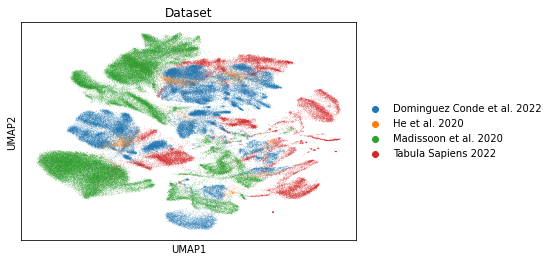

In [7]:
sc.pl.umap(adata, color = 'Dataset')

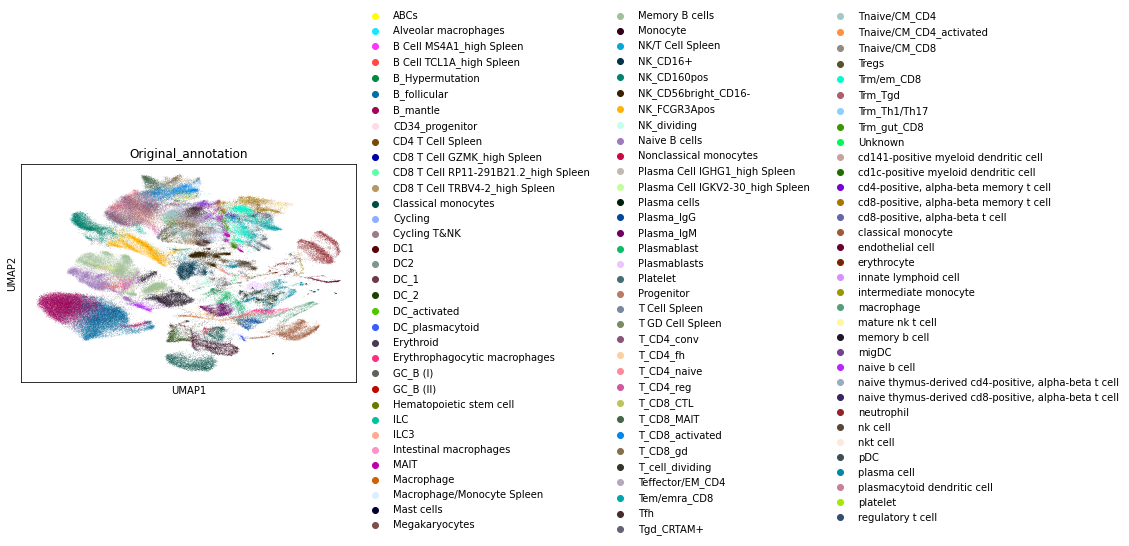

In [8]:
sc.pl.umap(adata, color = 'Original_annotation')

As expected, strong batches exist; meanwhile, cell types are annotated differently across studies (by different authors).

## Perform cell type harmonisation

The input AnnData needs two columns in `.obs` representing dataset origin and cell original annotation, respectively. We will use the function [cellhint.harmonize](https://cellhint.readthedocs.io/en/latest/cellhint.harmonize.html) to harmonise cell types across datasets.

In [9]:
import cellhint

In [10]:
alignment = cellhint.harmonize(adata, 'Dataset', 'Original_annotation')

👀 Detected PCA coordinates in the object, will use these to calculate distances
🏆 Reordering datasets
🖇 Harmonizing cell types of Dominguez Conde et al. 2022 and Madissoon et al. 2020
🖇 Harmonizing cell types of Tabula Sapiens 2022
🖇 Harmonizing cell types of He et al. 2020
🖋️ Reannotating cells
✅ Harmonization done!


By default, PCA (`X_pca`) is used as the search space, which is noisy as the batch effect is not corrected. However, this is usually not a problem for `cellhint.harmonize` due to an internal normalisation procedure applied. Please provide a different latent representation via the argument `use_rep` if you do have a better choice.

_If a very strong batch effect exists across datasets, you can turn on `use_pct = True` (default to `False`) to predict instead of calculate these distances in the space._

In CellHint, datasets are iteratively incorporated and harmonised. The order of datasets can be specified by providing a list of dataset names to the argument `dataset_order`. Otherwise, the order will be determined by CellHint through iteratively adding a dataset that is most similar (i.e., more shared cell types) to the datasets already incorporated. This behaviour can be disabled by setting `reorder_dataset = False` (default to `True`) and an alphabetical order of datasets will be used.

This function is very efficient in terms of runtime. If there are many datasets to harmonise and each dataset has many cell types, harmonisation may take longer time. You can restrict the test scope of `minimum_unique_percents` (default to 0.4, 0.5, 0.6, 0.7, 0.8) and `minimum_divide_percents` (default to 0.1, 0.15, 0.2) to reduce runtime. The default is a 15 (5X3) combo test; setting the two parameters to, for example a 3X2 combo (e.g., `minimum_unique_percents = [0.5, 0.6, 0.7], minimum_divide_percents = [0.1, 0.15]`), can decrease 60% of the runtime.

Check the summary information.

In [11]:
alignment

Cross-dataset cell type alignment for 4 datasets
    base_distance: a cross-dataset distance object
    aligned_datasets: 'Dominguez Conde et al. 2022', 'Madissoon et al. 2020', 'Tabula Sapiens 2022', 'He et al. 2020'
    relation: data frame of the harmonization table
    reannotation: data frame of the reannotated cells ('dataset', 'cell_type', 'reannotation', 'group')

Save the harmonisation result as a `.pkl` file.

In [12]:
alignment.write('cellhint_demo_folder/spleen_alignment.pkl')

## Inspect the harmonisation result

Load the previously saved harmonisation object.

In [13]:
alignment = cellhint.DistanceAlignment.load('cellhint_demo_folder/spleen_alignment.pkl')

### 1. Harmonisation table

In `alignment`, the harmonisation table, which summarises cell types across datasets into semantically connected ones, is stored as the attribute `.relation`.

One illustrative example of the harmonisation table is:
<div align="center">

  |D1   |relation|D2   |relation|D3        |
  |:---:|:---:   |:---:|:---:   |:---:     |
  |A    |=       |B    |=       |C         |
  |D    |=       |NONE |=       |UNRESOLVED|
  |E    |∈       |G    |=       |H         |
  |F    |∈       |G    |=       |I         |
  |J    |=       |K    |∋       |L         |
  |J    |=       |K    |∋       |M         |
  </div>

  The table columns are the dataset1 name, relation, dataset2 name, ..., all the way to the name of the last dataset. Accordingly, each row of the table is a list of cell types connected by predefined symbols of `=`, `∈`, and `∋`. In addition to cell type names, there are two extra definitions of `NONE` and `UNRESOLVED` in the table, representing two levels of novelties.  
    
  The table should be interpreted from left to right. For example, for the first row `A = B = C`, although it may look like an 1:1 match between A and B plus an 1:1 match between B and C, a correct interpretation should be an 1:1 match between A and B, resulting in a meta cell type of `A = B`. This meta cell type, as a whole, has an 1:1 match with C, further leading to `A = B = C`. Similarly, for the second row `D = NONE = UNRESOLVED`, instead of a novel cell type D in dataset1, this cell type should be read as a dataset1-specific cell type not existing in dataset2 (`D = NONE`), which as a whole is unharmonised when aligning with dataset3 (`D = NONE = UNRESOLVED`).  
    
  Extending this interpretation to the third and fourth rows, they denote two cell types (E and F) in dataset1 collectively constituting the cell type G in dataset2. The resulting subtypes (`E ∈ G` and `F ∈ G`) are 1:1 matched with H and I in dataset3, respectively. For the last two rows, they describe the subdivision of a meta cell type (`J = K`) into L and M in dataset3, being more than a subdivision of K.  
    
  In the table, each row corresponds to a harmonised low-hierarchy cell type, in other words, the most fine-grained level of annotation that can be achieved by automatic alignment. At a high hierarchy, some cell types such as `E ∈ G = H` and `F ∈ G = I` belong to the same group. CellHint defines a high-hierarchy cell type as fully connected rows in the harmonisation table. As a result, each high-hierarchy cell type is a cell type group independent of each other. This information can be accessed in the attribute `.groups` which is an array/vector with an length of the number of rows in the harmonisation table.

Show the harmonisation table.

In [14]:
# Note - `alignment.relation` is simply a Pandas data frame.
# Show the top 10 rows of the table.
alignment.relation.head(10)

,Dominguez Conde et al. 2022,relation,Madissoon et al. 2020,relation,Tabula Sapiens 2022,relation,He et al. 2020
0,Cycling T&NK,∋,NK_dividing,=,NONE,=,NONE
1,Cycling T&NK,∋,T_cell_dividing,=,"cd8-positive, alpha-beta t cell",=,NONE
2,Cycling,∈,Monocyte,∈,Hematopoietic stem cell,=,NONE
3,DC1,=,DC_1,∈,cd141-positive myeloid dendritic cell,=,NONE
4,DC2,=,DC_2,∈,cd141-positive myeloid dendritic cell,=,NONE
5,Erythroid,=,Unknown,=,erythrocyte,=,NONE
6,GC_B (I),=,B_Hypermutation,=,NONE,=,NONE
7,GC_B (II),=,NONE,=,NONE,=,NONE
8,ILC3,=,ILC,=,innate lymphoid cell,=,NONE
9,Mast cells,=,UNRESOLVED,=,UNRESOLVED,=,NONE


Show the cell type groups (high-hierarchy cell types).

In [15]:
alignment.groups

array(['Group1', 'Group1', 'Group2', 'Group3', 'Group3', 'Group4',
       'Group5', 'Group6', 'Group7', 'Group8', 'Group9', 'Group10',
       'Group11', 'Group12', 'Group13', 'Group2', 'Group14', 'Group15',
       'Group16', 'Group17', 'Group18', 'Group19', 'Group19', 'Group20',
       'Group20', 'Group19', 'Group19', 'Group2', 'Group2', 'Group21',
       'Group21', 'Group21', 'Group22', 'Group22', 'Group19', 'Group19',
       'Group23', 'Group23', 'Group19', 'Group19', 'Group16', 'Group16',
       'Group16', 'Group22', 'Group24', 'Group25', 'Group26'],
      dtype=object)

Couple the table (`alignment.relation`) with the grouping (`alignment.groups`) to examine what `Group22` is.

In [16]:
alignment.relation[alignment.groups == 'Group22']

,Dominguez Conde et al. 2022,relation,Madissoon et al. 2020,relation,Tabula Sapiens 2022,relation,He et al. 2020
9,Plasma cells,∋,Plasma_IgM,∈,plasma cell,∈,Plasma Cell IGHG1_high Spleen
10,Plasmablasts,=,Plasmablast,∈,plasma cell,∈,Plasma Cell IGHG1_high Spleen
3,Plasma cells,∋,Plasma_IgG,∈,plasma cell,=,UNRESOLVED


Three low-hierarchy cell types (i.e., the three rows above, corresponding to `IgM plasma cells`, `plasmablasts`, and `IgG plasma cells`) are shown to collectively constitute a high-hierarchy cell type (i.e., `Group22`, the plasma cells). Therefore, by connecting cell types across datasets, we obtain a biological grouping scheme for plasma cells, which also represents a means to integrate _knowledge_ across studies.

### 2. Cell reannotation

After cell type harmonisation, each cell can be assigned a cell type label corresponding to a given row of the harmonisation table, denoted as the process of cell reannotation. By default, reannotation is enabled (`reannotate = True`) when using [cellhint.harmonize](https://cellhint.readthedocs.io/en/latest/cellhint.harmonize.html) and information of reannotated cell types is already in place as the attribute `.reannotation`.  
  
  An illustrative example is shown below.
  <div align="center">

  |     |dataset|cell_type|reannotation         |group |
  |:---:|:---:  |:---:    |:---:                |:---: |
  |cell1|D1     |A        |A = B = C            |Group1|
  |cell2|D1     |D        |D = NONE = UNRESOLVED|Group2|
  |cell3|D2     |G        |E ∈ G = H            |Group3|
  |cell4|D2     |G        |F ∈ G = I            |Group3|
  |cell5|D3     |L        |J = K ∋ L            |Group4|
  |cell6|D3     |M        |J = K ∋ M            |Group4|
  </div>

  The four columns represent information of dataset origin, original author annotation, reannotated low- and high-hierarchy annotation, respectively. As mentioned earlier, for the last column, it contains grouping (high-hierarchy) information, and each group corresponds to a subset of the harmonisation table. You can check this correspondence by coupling the table (`alignment.relation`) with the grouping (`alignment.groups`).

Check the cell reannotation.

In [17]:
alignment.reannotation

,dataset,cell_type,reannotation,group
ID,,,,
AAACCTGCACATTTCT-1-HCATisStab7463846,Madissoon et al. 2020,T_CD8_MAIT,"MAIT = T_CD8_MAIT ∈ cd8-positive, alpha-beta m...",Group19
AAACCTGCACCGCTAG-1-HCATisStab7463846,Madissoon et al. 2020,NK_CD160pos,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
AAACCTGCAGTCCTTC-1-HCATisStab7463846,Madissoon et al. 2020,T_CD8_activated,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
AAACCTGCATTGGCGC-1-HCATisStab7463846,Madissoon et al. 2020,B_mantle,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
AAACCTGCATTTCACT-1-HCATisStab7463846,Madissoon et al. 2020,NK_CD160pos,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
...,...,...,...,...
Spleen_cDNA_TTTGGTTTCGTCCAGG-1,He et al. 2020,CD8 T Cell TRBV4-2_high Spleen,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
Spleen_cDNA_TTTGTCAAGGAGTTTA-1,He et al. 2020,B Cell TCL1A_high Spleen,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
Spleen_cDNA_TTTGTCACAAGCGATG-1,He et al. 2020,NK/T Cell Spleen,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21


Note that the last two columns place __all__ cells under one naming schema, which can be used for supervised data integration (details in this [notebook](https://colab.research.google.com/github/Teichlab/cellhint/blob/main/docs/notebook/cellhint_tutorial_integration.ipynb)).

Insert the last two columns into the `.obs` of the AnnData if needed.

In [18]:
adata.obs[['low_hierarchy', 'high_hierarchy']] = alignment.reannotation.loc[adata.obs_names, ['reannotation', 'group']]
adata.obs[['low_hierarchy', 'high_hierarchy']]

,low_hierarchy,high_hierarchy
AAACCTGCACATTTCT-1-HCATisStab7463846,"MAIT = T_CD8_MAIT ∈ cd8-positive, alpha-beta m...",Group19
AAACCTGCACCGCTAG-1-HCATisStab7463846,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
AAACCTGCAGTCCTTC-1-HCATisStab7463846,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
AAACCTGCATTGGCGC-1-HCATisStab7463846,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
AAACCTGCATTTCACT-1-HCATisStab7463846,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
...,...,...
Spleen_cDNA_TTTGGTTTCGTCCAGG-1,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
Spleen_cDNA_TTTGTCAAGGAGTTTA-1,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
Spleen_cDNA_TTTGTCACAAGCGATG-1,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21
Spleen_cDNA_TTTGTCACAGGGATTG-1,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21


### 3. Meta-analysis

A distance matrix-like instance, which is from the class `Distance` as defined by CellHint, is also stashed in `alignment` as the attribute `.base_distance`.

In [19]:
alignment.base_distance

Cross-dataset distance matrix between 200664 cells and 102 cell types from 4 datasets
    dist_mat: distance matrix between 200664 cells and 102 cell types
    cell: cell meta-information ('dataset', 'ID', 'cell_type')
    cell_type: cell type meta-information ('dataset', 'cell_type')
    assignment: data frame of cross-dataset cell type assignment

The main content of this object is the distance matrix (`alignment.base_distance.dist_mat`) between all cells (rows) and all cell types (columns). Values in this matrix are either calculated (the default) or inferred (if `use_pct` is `True`) by `cellhint.harmonize`, and after a normalisation procedure, lie between 0 and 1. If there are strong cross-dataset batches, an inferred distance matrix obtained from the PCT algorithm is usually more accurate. Metadata of cells and cell types for this matrix can be found in `alignment.base_distance.cell` and `alignment.base_distance.cell_type`, which record raw information such as the dataset origin and original author annotation.

During the internal harmonisation process, each cell is assigned the most similar cell type from each dataset. This result is stored in the assignment matrix (`alignment.base_distance.assignment`), with rows being cells (cell metadata can be found in `alignment.base_distance.cell` as mentioned above), columns being datasets, and elements being the assigned cell types in different datasets. This matrix can be interpreted as a summary of multi-data label transfers.

In [20]:
alignment.base_distance.assignment

,Dominguez Conde et al. 2022,He et al. 2020,Madissoon et al. 2020,Tabula Sapiens 2022
0,Trm/em_CD8,T Cell Spleen,T_CD8_MAIT,"cd8-positive, alpha-beta memory t cell"
1,NK_CD56bright_CD16-,NK/T Cell Spleen,NK_CD160pos,mature nk t cell
2,Trm/em_CD8,CD8 T Cell TRBV4-2_high Spleen,T_CD8_activated,"cd8-positive, alpha-beta memory t cell"
3,Memory B cells,B Cell MS4A1_high Spleen,B_mantle,memory b cell
4,NK_CD56bright_CD16-,NK/T Cell Spleen,NK_CD160pos,mature nk t cell
...,...,...,...,...
200659,Trm/em_CD8,CD8 T Cell TRBV4-2_high Spleen,T_CD8_activated,"cd8-positive, alpha-beta memory t cell"
200660,Naive B cells,B Cell TCL1A_high Spleen,B_mantle,naive b cell
200661,NK_CD16+,NK/T Cell Spleen,NK_FCGR3Apos,nk cell
200662,NK_CD16+,NK/T Cell Spleen,NK_FCGR3Apos,"naive thymus-derived cd8-positive, alpha-beta ..."


Each column (corresponding to one dataset) of the assignment matrix can be thought as a unified naming schema when all cells are named by this given dataset.

CellHint provides a quick way to summarise the above information including cells' distances and assignments into meta-analysis at the cell type level. Specifically, a distance matrix among all cell types can be obtained by:

In [21]:
dist_mat = alignment.base_distance.to_meta()
dist_mat.iloc[:5, :5]

,Dominguez Conde et al. 2022: ABCs,Dominguez Conde et al. 2022: Alveolar macrophages,Dominguez Conde et al. 2022: Classical monocytes,Dominguez Conde et al. 2022: Cycling,Dominguez Conde et al. 2022: Cycling T&NK
Dominguez Conde et al. 2022: ABCs,0.033654,0.687288,0.801163,0.724286,0.622591
Dominguez Conde et al. 2022: Alveolar macrophages,0.687288,0.312455,0.691563,0.720285,0.794949
Dominguez Conde et al. 2022: Classical monocytes,0.801163,0.691563,0.200593,0.600125,0.854416
Dominguez Conde et al. 2022: Cycling,0.724286,0.720285,0.600125,0.312228,0.725105
Dominguez Conde et al. 2022: Cycling T&NK,0.622591,0.794949,0.854416,0.725105,0.207789


An optional `turn_binary = True` (default to `False`) can be added to turn the distance matrix into a cell membership matrix before meta-analysis, showing how cell types are assigned across datasets.

In [22]:
member_mat = alignment.base_distance.to_meta(turn_binary = True)
member_mat.iloc[:5, :5]

,Dominguez Conde et al. 2022: ABCs,Dominguez Conde et al. 2022: Alveolar macrophages,Dominguez Conde et al. 2022: Classical monocytes,Dominguez Conde et al. 2022: Cycling,Dominguez Conde et al. 2022: Cycling T&NK
Dominguez Conde et al. 2022: ABCs,0.715729,0.000000,0.000263,0.000000,0.000000
Dominguez Conde et al. 2022: Alveolar macrophages,0.000000,0.736842,0.001838,0.000000,0.000000
Dominguez Conde et al. 2022: Classical monocytes,0.000263,0.001838,0.848792,0.013826,0.000000
Dominguez Conde et al. 2022: Cycling,0.000000,0.000000,0.013826,0.756757,0.040541
Dominguez Conde et al. 2022: Cycling T&NK,0.000000,0.000000,0.000000,0.040541,0.722667


The two matrices (`dist_mat` and `member_mat`) can be used for different purposes. Here we cluster all cell types based on the membership matrix.

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


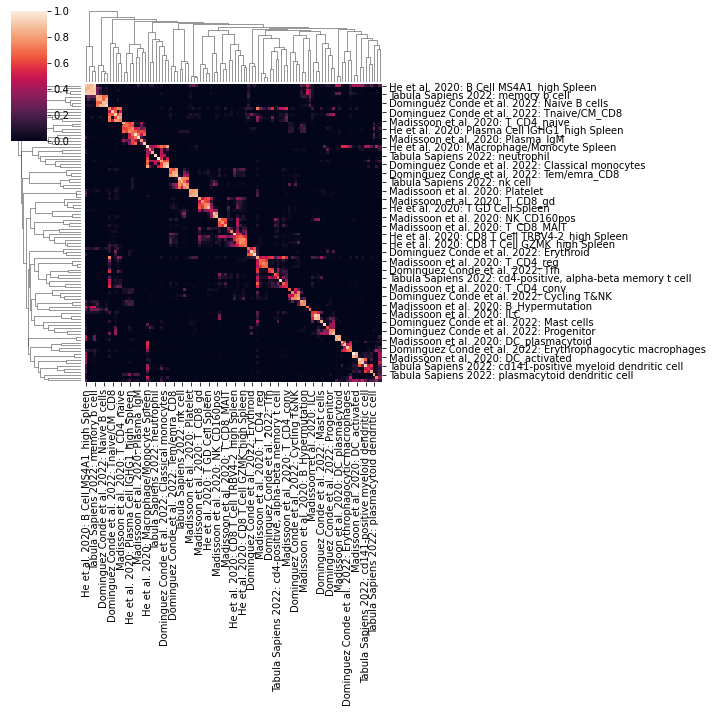

In [23]:
import seaborn as sns
sns.clustermap(member_mat)

This heatmap shows how cell types are cross-assigned across studies. There are too many cell types here; try to subset the two matrices and visualise part of the heatmap if needed. For example, extract cell types that contain the string `DC`.

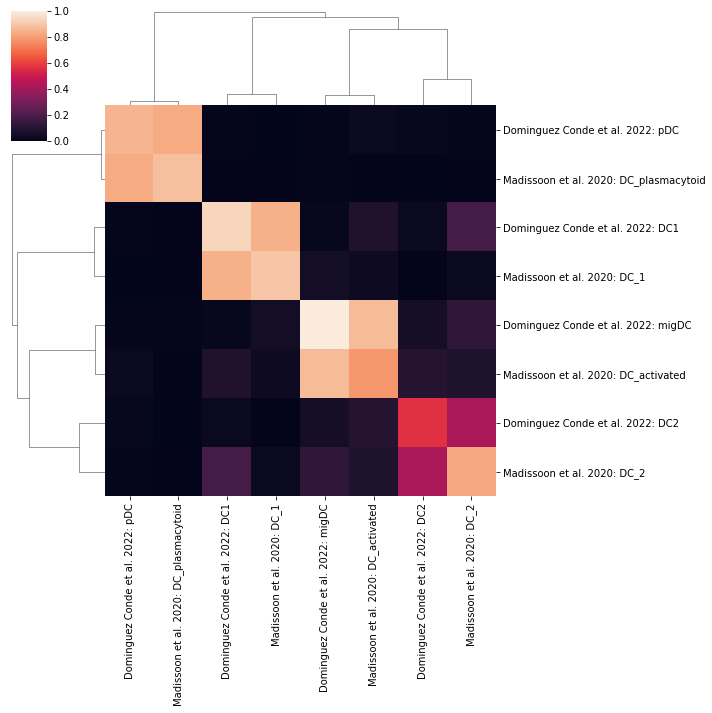

In [24]:
flag = member_mat.index.str.contains('DC')
sns.clustermap(member_mat.loc[flag,flag])

## Visualise the harmonisation result

### Tree plot

The most intuitive way to visualise the harmonised cell types is the tree plot using the function [cellhint.treeplot](https://cellhint.readthedocs.io/en/latest/cellhint.treeplot.html).

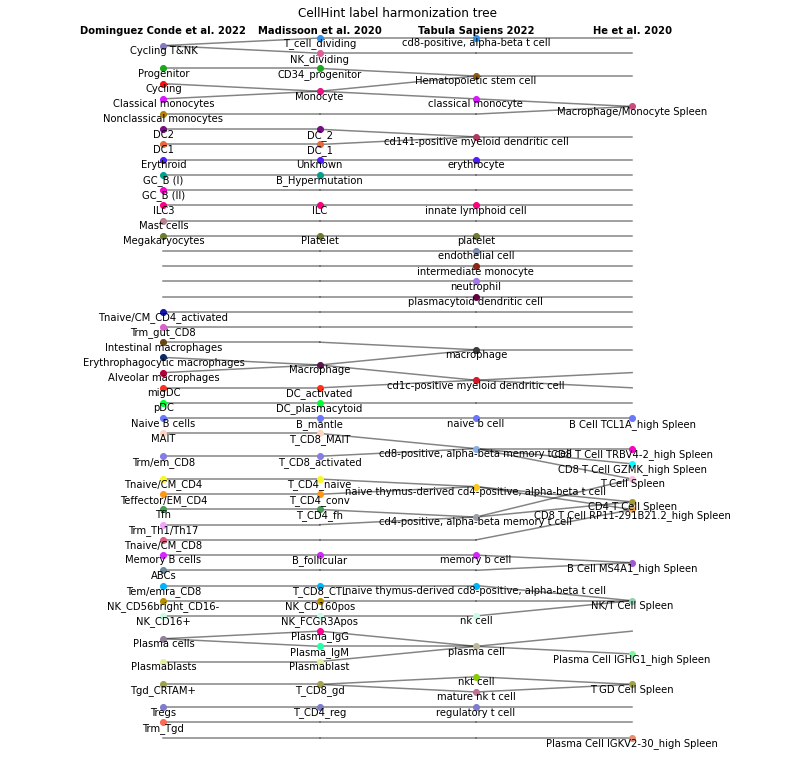

In [25]:
cellhint.treeplot(alignment)

In a tree plot, each column is a dataset and cell types are connected across datasets. By default, cell types belonging to one low hierarchy (one row in the harmonisation table) are in the same color. You can change the color scheme by providing a data frame to the `node_color` parameter, with three consecutive columns representing dataset, cell type, and color (in hex code), respectively. `node_color` can also be a data frame with columns of dataset, cell type, and numeric value (for mapping color gradient in combination with `cmap`). Other parameters controlling the appearance of the tree plot (node shape, line width, label size, figure size, etc.) are detailed in [cellhint.treeplot](https://cellhint.readthedocs.io/en/latest/cellhint.treeplot.html).

By changing the dataset (column) order in each high-hierarchy cell type, broader (more divisible) cell types can be positioned to the left, followed by fine-grained cell types to the right. The resulting plot shows how different authors group these cell types, thereby being more characteristic of the potential underlying biological hierarchy. This hierarchy can be generated and visualised by adding `order_dataset = True`.

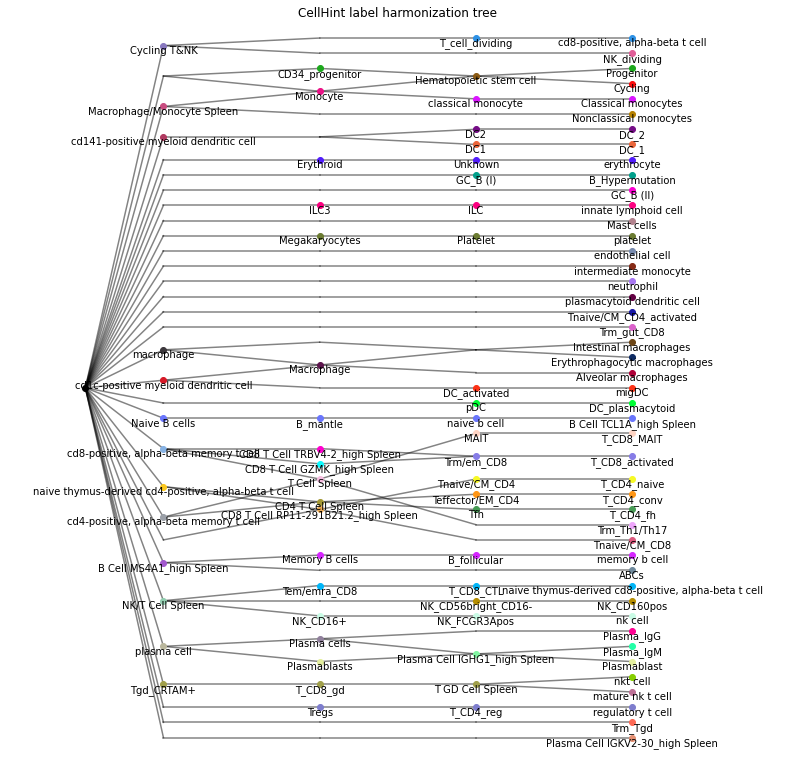

In [26]:
cellhint.treeplot(alignment, order_dataset = True)

Because each high-hierarchy cell type is independent of each other, the new orders of datasets will be different across groups. To recognise the dataset origin of each cell type within the hierarchy, you can assign the same color or shape to cell types from the same dataset using the parameter `node_color` or `node_shape`.

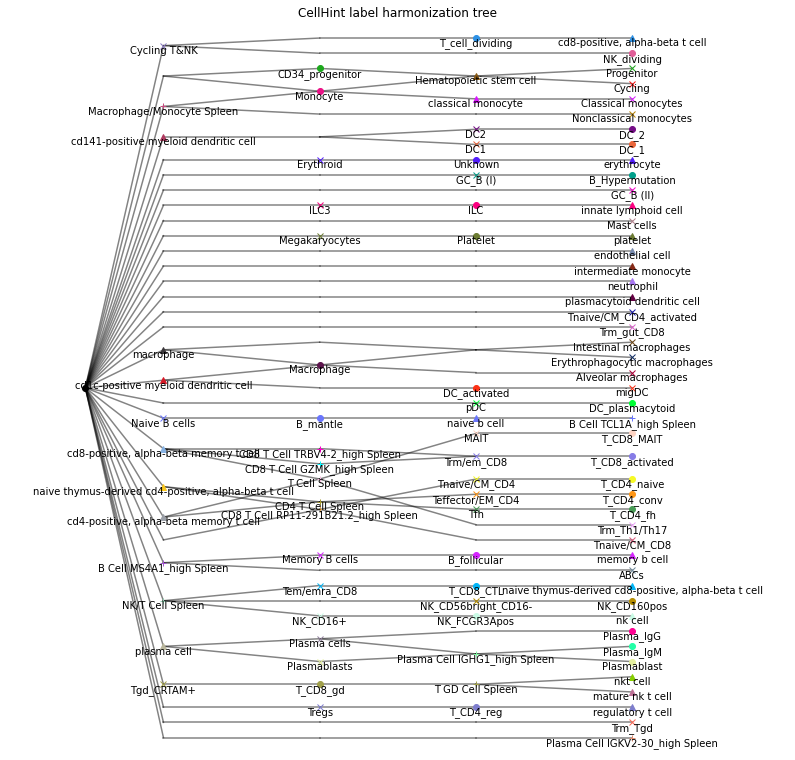

In [27]:
cellhint.treeplot(alignment, order_dataset = True, node_shape = ['x', 'o', '^', '+'])

Alternatively, since only the harmonisation table (`alignment.relation`) is used when plotting this tree, `cellhint.treeplot` also accepts the input directly from the table. This is more convenient as a table is easier to manipulate, such as writing it out as a csv file and loading it later for tree plot.

In [28]:
# Write out the harmonisation table as a csv file.
# Note - if cell type names contain commas, set a different `sep` here.
alignment.relation.to_csv('cellhint_demo_folder/Spleen_HT.csv', sep = ',', index = False)

Read the harmonisation table and visualise top 20 rows.

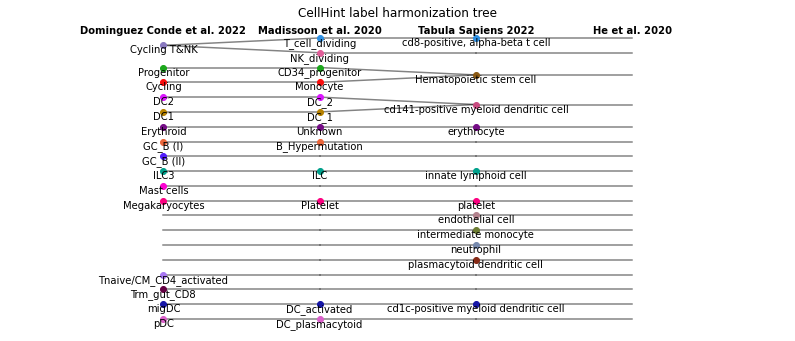

In [29]:
import pandas as pd
HT = pd.read_csv('cellhint_demo_folder/Spleen_HT.csv', sep = ',')
cellhint.treeplot(HT.iloc[:20])

Visualise `Group22`.

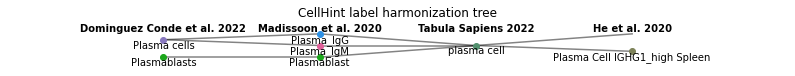

In [30]:
cellhint.treeplot(alignment.relation[alignment.groups == 'Group22'])

In the tree plot, the order of datasets is the same with that in the harmonisation table (`alignment.relation`).  
  
CellHint provides a method `.best_align()` to change the order of datasets post-harmonisation. Through this, datasets will be reharmonised in a different order (this post-harmonisation adjustment is more efficient than re-running `cellhint.harmonize` with a new order).

In [31]:
alignment.best_align(dataset_order = ['Tabula Sapiens 2022', 'He et al. 2020', 'Madissoon et al. 2020', 'Dominguez Conde et al. 2022'])

🖇 Harmonizing cell types of Tabula Sapiens 2022 and He et al. 2020
🖇 Harmonizing cell types of Madissoon et al. 2020
🖇 Harmonizing cell types of Dominguez Conde et al. 2022


A new harmonisation table will be generated in `alignment.relation` with the same dataset order as specified in `.best_align`.

In [32]:
alignment.relation.head(10)

,Tabula Sapiens 2022,relation,He et al. 2020,relation,Madissoon et al. 2020,relation,Dominguez Conde et al. 2022
0,endothelial cell,=,NONE,=,NONE,=,NONE
1,intermediate monocyte,=,NONE,=,NONE,=,NONE
2,neutrophil,=,NONE,=,NONE,=,NONE
0,NONE,=,NONE,=,NONE,=,ABCs
1,NONE,=,NONE,=,NONE,=,GC_B (II)
2,NONE,=,NONE,=,NONE,=,Tnaive/CM_CD4_activated
3,NONE,=,NONE,=,NONE,=,Trm_Tgd
4,NONE,=,NONE,=,NONE,=,Trm_gut_CD8
0,NONE,=,NONE,=,DC_plasmacytoid,=,pDC
1,UNRESOLVED,=,UNRESOLVED,=,B_Hypermutation,=,GC_B (I)


After changing the dataset order and reharmonising cell types, cells need to be reannotated based on the newly generated harmonisation table using the method `reannotate`.

In [33]:
alignment.reannotate()

Similarly, new information of reannotated cells is stored in `alignment.reannotation`.

Visualise this harmonisation result which now has a new dataset order.

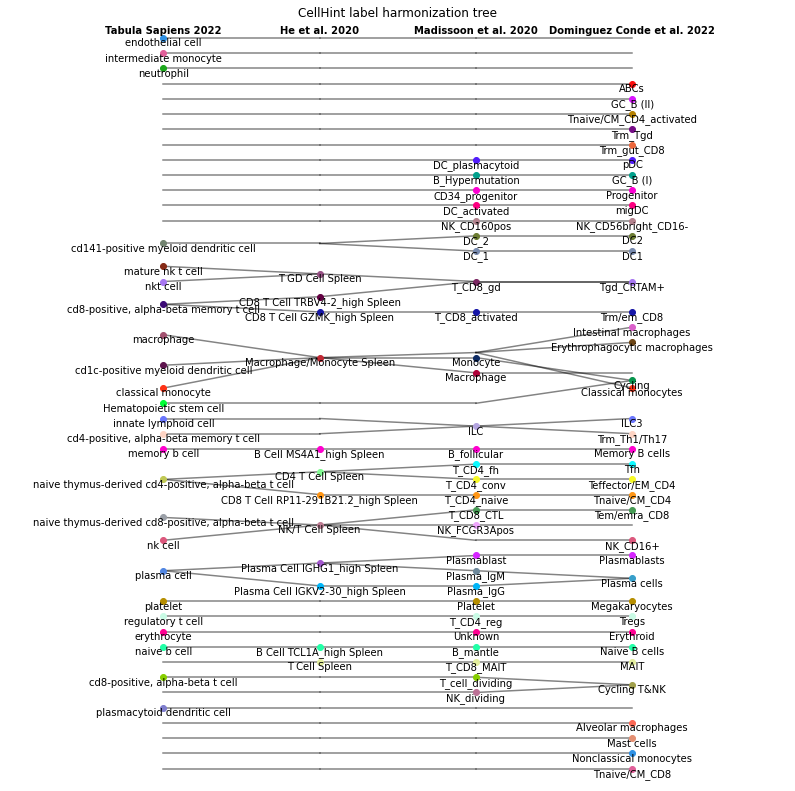

In [34]:
cellhint.treeplot(alignment)

Importantly, as well as a full dataset list, you can provide a subset of datasets for reharmonisation in `.best_align`. This is useful in terms of focusing on part of the data.

In [35]:
alignment.best_align(dataset_order = ['Tabula Sapiens 2022', 'He et al. 2020'])

🖇 Harmonizing cell types of Tabula Sapiens 2022 and He et al. 2020


In [36]:
alignment.reannotate()

Note that after `best_align` and `reannotate`,new `alignment.relation` and `alignment.reannotation` will overwrite the old ones.

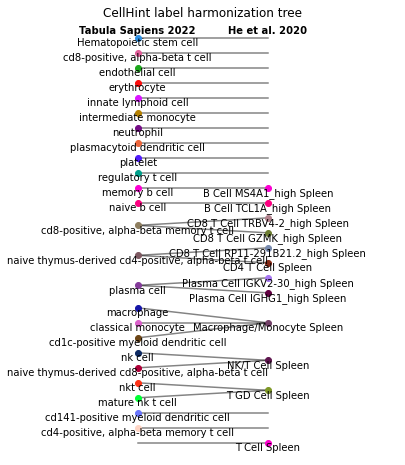

In [37]:
cellhint.treeplot(alignment)

### Sankey plot

The other way to visualise harmonised cell types is the Sankey plot by [cellhint.sankeyplot](https://cellhint.readthedocs.io/en/latest/cellhint.sankeyplot.html). CellHint builds this plot on the [plotly](https://pypi.org/project/plotly) package. `plotly` is not mandatory when installing CellHint, so you need to install it first if you want a visualisation form of Sankey diagram (and engines for exporting images such as [kaleido](https://pypi.org/project/kaleido)).

In [38]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [39]:
# Load previously saved harmonisation result and visualise it.
alignment = cellhint.DistanceAlignment.load('cellhint_demo_folder/spleen_alignment.pkl')
cellhint.sankeyplot(alignment)

This diagram shows how cell types are connected across datasets. Parameters controlling the appearance of the Sankey plot (node color, link color, figure size, etc.) are detailed in [cellhint.sankeyplot](https://cellhint.readthedocs.io/en/latest/cellhint.sankeyplot.html).

Similar to the tree plot, since only the harmonisation table (`alignment.relation`) is used when plotting this Sankey diagram, `cellhint.sankeyplot` also accepts the input directly from the table. Thus you can manipulate this table and visualise it flexibly.

In [40]:
# Visualise top 30 rows for example.
cellhint.sankeyplot(alignment.relation.iloc[:30])

Export the plot if needed.

In [41]:
# Export the image as html.
cellhint.sankeyplot(alignment, show = False, save = 'cellhint_demo_folder/Spleen_sankey.html')
# Export the image as pdf.
cellhint.sankeyplot(alignment, show = False, save = 'cellhint_demo_folder/Spleen_sankey.pdf')